In [1]:
import pandas as pd 
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from datetime import datetime
!pip install xlrd
%matplotlib inline 

In [5]:
# load dataframe
dfs = pd.read_excel("Adventure Works_Database.xlsx",sheet_name="Sheet3")
print(dfs.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   CustomerKey           18484 non-null  int64         
 1   FirstName             18484 non-null  object        
 2   LastName              18484 non-null  object        
 3   FullName              18484 non-null  object        
 4   BirthDate             18484 non-null  datetime64[ns]
 5   MaritalStatus         18484 non-null  object        
 6   Gender                18484 non-null  object        
 7   YearlyIncome          18484 non-null  int64         
 8   TotalChildren         18484 non-null  int64         
 9   NumberChildrenAtHome  18484 non-null  int64         
 10  Education             18484 non-null  object        
 11  Occupation            18484 non-null  object        
 12  HouseOwnerFlag        18484 non-null  int64         
 13  NumberCarsOwned 

In [7]:
dfs['Gender'] = dfs['Gender'].astype('category')
dfs['MaritalStatus'] = dfs['MaritalStatus'].astype('category')
dfs['Education'] = dfs['Education'].astype('category')
dfs['Occupation'] = dfs['Occupation'].astype('category')
dfs['CommuteDistance'] = dfs['CommuteDistance'].astype('category')
cat_columns = dfs.select_dtypes(['category']).columns
dfs[cat_columns] = dfs[cat_columns].apply(lambda x: x.cat.codes)
df = dfs.select_dtypes(exclude=['object'])
df=df.dropna()
df['AgeFirstPurchase']=(df['DateFirstPurchase'].dt.year-df['BirthDate'].dt.year).astype(int)
df['BirthDate']=df[['BirthDate']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
df['DateFirstPurchase']=df[['DateFirstPurchase']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
df.head()



,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,AgeFirstPurchase
0,11000,-117849600,0,1,90000,2,0,0,3,1,0,1390348800,1,48
1,11001,-146275200,1,1,60000,3,3,0,3,0,1,1390003200,0,49
2,11002,-138499200,0,1,60000,3,3,0,3,1,1,1389312000,3,49
3,11003,-59270400,1,0,70000,0,0,0,3,0,1,1388534400,4,46
4,11004,-44150400,1,0,80000,5,5,0,3,1,4,1390694400,1,46


In [8]:
obsolete_columns = [
    'CustomerKey',
    'BirthDate',
    'DateFirstPurchase'
]
df.drop(columns=obsolete_columns, inplace=True)
df.head()

,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,CommuteDistance,AgeFirstPurchase
0,0,1,90000,2,0,0,3,1,0,1,48
1,1,1,60000,3,3,0,3,0,1,0,49
2,0,1,60000,3,3,0,3,1,1,3,49
3,1,0,70000,0,0,0,3,0,1,4,46
4,1,0,80000,5,5,0,3,1,4,1,46


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17918 entries, 0 to 18483
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   MaritalStatus         17918 non-null  int8 
 1   Gender                17918 non-null  int8 
 2   YearlyIncome          17918 non-null  int64
 3   TotalChildren         17918 non-null  int64
 4   NumberChildrenAtHome  17918 non-null  int64
 5   Education             17918 non-null  int8 
 6   Occupation            17918 non-null  int8 
 7   HouseOwnerFlag        17918 non-null  int64
 8   NumberCarsOwned       17918 non-null  int64
 9   CommuteDistance       17918 non-null  int8 
 10  AgeFirstPurchase      17918 non-null  int64
dtypes: int64(6), int8(5)
memory usage: 1.0 MB
None


In [10]:
df.describe()

,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,CommuteDistance,AgeFirstPurchase
count,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000
mean,0.458198,0.506586,57341.221118,1.834133,1.001228,1.686070,2.308014,0.676192,1.496819,1.662016,53.942516
std,0.498263,0.499971,32279.351991,1.608377,1.520928,1.361843,1.411944,0.467941,1.138000,1.517202,11.279175
min,0.000000,0.000000,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000
25%,0.000000,0.000000,30000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,45.000000
50%,0.000000,1.000000,60000.000000,2.000000,0.000000,2.000000,3.000000,1.000000,2.000000,1.000000,52.000000
75%,1.000000,1.000000,70000.000000,3.000000,2.000000,3.000000,3.000000,1.000000,2.000000,3.000000,61.000000
max,1.000000,1.000000,170000.000000,5.000000,5.000000,4.000000,4.000000,1.000000,4.000000,4.000000,106.000000


In [ ]:
df_norm=df.copy()
names = df.columns
min_max_scaler = preprocessing.MinMaxScaler()
df_norm = pd.DataFrame(min_max_scaler.fit_transform(df), columns=names)
df_norm

,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,CommuteDistance,AgeFirstPurchase
0,0.0,1.0,0.5000,0.4,0.0,0.00,0.75,1.0,0.00,0.25,0.194444
1,1.0,1.0,0.3125,0.6,0.6,0.00,0.75,0.0,0.25,0.00,0.208333
2,0.0,1.0,0.3125,0.6,0.6,0.00,0.75,1.0,0.25,0.75,0.208333
3,1.0,0.0,0.3750,0.0,0.0,0.00,0.75,0.0,0.25,1.00,0.166667
4,1.0,0.0,0.4375,1.0,1.0,0.00,0.75,1.0,1.00,0.25,0.166667
...,...,...,...,...,...,...,...,...,...,...,...
17913,0.0,1.0,0.1250,0.2,0.0,0.25,0.00,1.0,0.00,0.00,0.319444
17914,1.0,0.0,0.1250,0.6,0.0,0.25,0.00,1.0,0.00,0.00,0.305556
17915,1.0,1.0,0.1250,0.6,0.0,0.25,0.00,0.0,0.00,0.00,0.277778
17916,0.0,1.0,0.1250,0.6,0.0,0.00,0.00,1.0,0.00,0.00,0.305556


In [11]:
scaled_df=df.copy()
scaled_df[['YearlyIncome']] = preprocessing.StandardScaler().fit_transform(df[['YearlyIncome']])
scaled_df

,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,CommuteDistance,AgeFirstPurchase
0,0,1,1.011783,2,0,0,3,1,0,1,48
1,1,1,0.082370,3,3,0,3,0,1,0,49
2,0,1,0.082370,3,3,0,3,1,1,3,49
3,1,0,0.392174,0,0,0,3,0,1,4,46
4,1,0,0.701979,5,5,0,3,1,4,1,46
...,...,...,...,...,...,...,...,...,...,...,...
18479,0,1,-0.847043,1,0,1,0,1,0,0,57
18480,1,0,-0.847043,3,0,1,0,1,0,0,56
18481,1,1,-0.847043,3,0,1,0,0,0,0,54
18482,0,1,-0.847043,3,0,0,0,1,0,0,56


In [12]:
# PCA
pca = PCA(n_components=2)
X=pca.fit_transform(scaled_df)
print(pca.explained_variance_ratio_)

[0.90680507 0.02679721]


In [13]:
X[:10]

array([[-5.94083408, -0.61036097],
       [-4.88727491,  1.75199584],
       [-4.82473395,  2.38730611],
       [-8.0376925 , -0.81248243],
       [-7.63438275,  5.76111245],
       [-5.04388214, -0.92763436],
       [-5.04384511, -0.92690372],
       [-3.85799574,  2.11304298],
       [-3.73764182,  4.02463038],
       [-4.05196023, -1.01527837]])

In [14]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

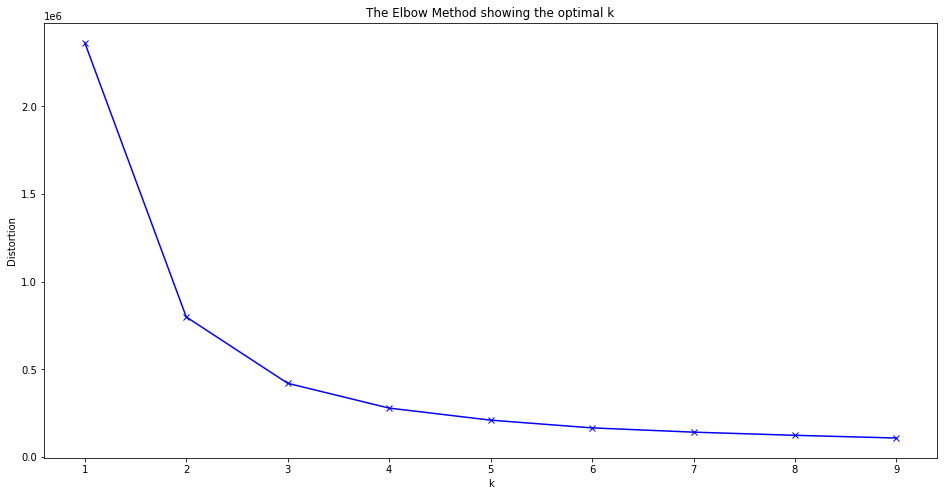

In [15]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [16]:
kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(X)
X_cluster=kmeanModel.predict(X)
df_kmeans=pd.DataFrame(X, columns=['pc1','pc2'])
df_kmeans['cluster']=X_cluster+1
df_kmeans

,pc1,pc2,cluster
0,-5.940834,-0.610361,3
1,-4.887275,1.751996,3
2,-4.824734,2.387306,3
3,-8.037693,-0.812482,3
4,-7.634383,5.761112,3
...,...,...,...
17913,2.972538,-2.665653,1
17914,2.117442,-1.637865,1
17915,0.120000,-1.574691,1
17916,2.129390,-1.647044,1


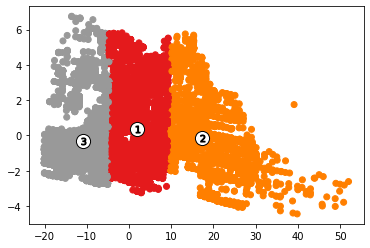

In [17]:
plt.scatter(df_kmeans['pc1'], df_kmeans['pc2'], c=df_kmeans['cluster'], cmap=plt.cm.Set1)
centers = kmeanModel.cluster_centers_
    # Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % (i+1), alpha=1,
                s=50, edgecolor='k')

plt.show()

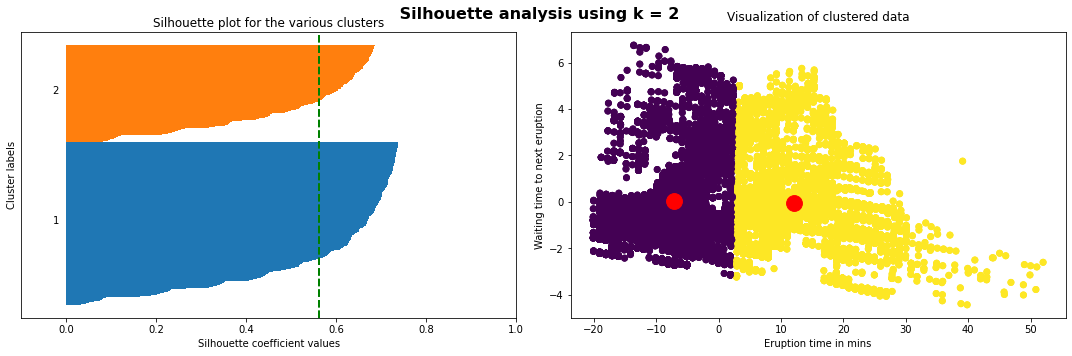

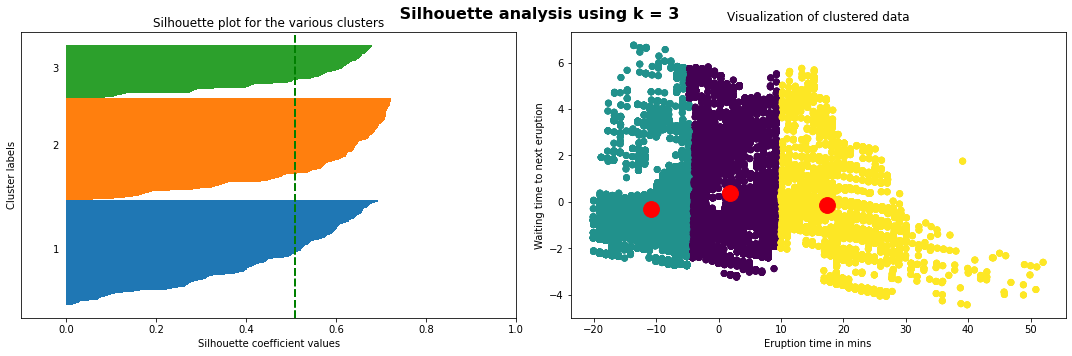

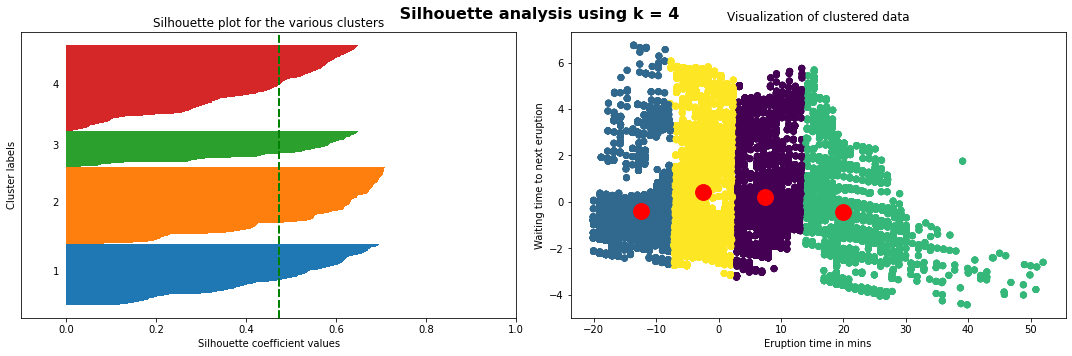

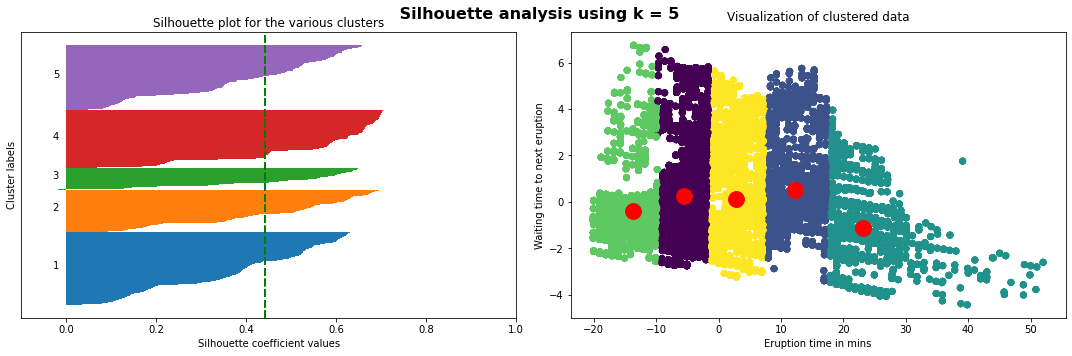

In [19]:
for i,k in enumerate([2,3,4,5]):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    # Run the kmeans algorithm
    km = KMeans(n_clusters=k)
    y_predict = km.fit_predict(X)
    centroids  = km.cluster_centers_
    # get silhouette
    silhouette_vals = silhouette_samples(X,y_predict)
        #silhouette_vals
    # silhouette plot
    y_ticks = []
    y_lower = y_upper = 0
    for i,cluster in enumerate(np.unique(y_predict)):
      cluster_silhouette_vals = silhouette_vals[y_predict ==cluster]
      cluster_silhouette_vals.sort()
      y_upper += len(cluster_silhouette_vals)
      
      ax[0].barh(range(y_lower,y_upper),
      cluster_silhouette_vals,height =1);
      ax[0].text(-0.03,(y_lower+y_upper)/2,str(i+1))
      y_lower += len(cluster_silhouette_vals)
          
      # Get the average silhouette score 
      avg_score = np.mean(silhouette_vals)
      ax[0].axvline(avg_score,linestyle ='--',
      linewidth =2,color = 'green')
      ax[0].set_yticks([])
      ax[0].set_xlim([-0.1, 1])
      ax[0].set_xlabel('Silhouette coefficient values')
      ax[0].set_ylabel('Cluster labels')
      ax[0].set_title('Silhouette plot for the various clusters');
      # scatter plot of data colored with labels
      ax[1].scatter(X[:,0] ,X[:,1], c = y_predict);
      ax[1].scatter(centroids[:,0],centroids[:,1],
      marker = 'o' , c= 'r',s =250);
      ax[1].set_xlabel('Eruption time in mins')
      ax[1].set_ylabel('Waiting time to next eruption')
      ax[1].set_title('Visualization of clustered data', y=1.02)

      plt.tight_layout()
      plt.suptitle(f' Silhouette analysis using k = {k}',fontsize=16,fontweight = 'semibold')


